<a href="https://colab.research.google.com/github/JayNguyen-123/Image_Similarity_Search/blob/main/Image_Similarity_Search_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Recommending Similar Images using Image Embedding

- When a customer show interest in a product by browsing its page, he/she will probaly be inclined to show interest in similar product and this is what E-commercial websites use such recommender systems.

### Image Embedding
- Imagin when we have a 1080p image, we need to store 1920 x 1080 x 3 = 6,220,800 pixels. These pixels are the visual representation of information like people, objects, etc. Since, we are trying to build an image recommendation system, using ~6M pixels to identify similarities will be computationally expensive.

- Instead using image pixels, we can use Image Embedding. Image Embedding can be thought of vector representation of an image. It captures the image features and information into a vector format.

### Similar Images Finder using MobiNetV2 and Dataset "Image Alike"

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [ ]:
path_val = '/content/drive/MyDrive/similar_image/validate.csv'
path_to_images = '/content/drive/MyDrive/similar_image/images'

# Utility GPU or CPU

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], "GPU")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Yes")
    except Exception as e:
        print(e)
else:
    print('Not available GPU')

Yes


Load data and preprocess them

In [ ]:
def load_and_preprocess_images(path_dir, image_size=(224, 224)):
    images_paths = [os.path.join(path_dir, f) for f in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir, f))]
    dataset = []

    for img_path in tqdm(images_paths, desc='Loading and preprocessing images'):
        try:
            image = load_img(img_path, target_size = image_size)
            image = img_to_array(image)
            img_batch = np.expand_dims(image, axis=0)
            img_preprocess = preprocess_input(img_batch)
            dataset.append(img_preprocess)
        except Exception as e:
            print(f"ERROR loading image {img_path}::{e}")
            continue

    return np.concatenate(dataset, axis=0), images_paths


In [ ]:
dataset, images_paths = load_and_preprocess_images(path_to_images)

Loading and preprocessing images:  34%|███▍      | 1040/3072 [00:58<00:09, 212.58it/s]

ERROR loading image /content/drive/MyDrive/similar_image/images/validate.csv::cannot identify image file <_io.BytesIO object at 0x798a28e64270>


Loading and preprocessing images: 100%|██████████| 3072/3072 [01:05<00:00, 47.05it/s] 


In [ ]:
dataset.shape


(3071, 224, 224, 3)

MobileNetV2

In [ ]:
def get_images_vectors(images):
    model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
    vectors = model.predict(images)
    return vectors

MobileNet50v2

In [ ]:
def get_images_vectors(images):
    model = ResNet50V2(weights='imagenet', include_top=False, pooling='avg')
    vectors = model.predict(images)
    return vectors

In [ ]:
vectors = get_images_vectors(dataset)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step


In [ ]:
embedded_images = pd.DataFrame({'Pahts': images_paths, "Embedding": vectors.tolist()})
embedded_images.head()


,Pahts,Embedding
0,/content/drive/MyDrive/similar_image/images/11...,"[0.6931028962135315, 1.4978790283203125, 0.219..."
1,/content/drive/MyDrive/similar_image/images/11...,"[0.08990578353404999, 0.0, 0.09551095962524414..."
2,/content/drive/MyDrive/similar_image/images/11...,"[0.43340206146240234, 0.4547800123691559, 1.24..."
3,/content/drive/MyDrive/similar_image/images/11...,"[0.0, 2.284883499145508, 1.8022971153259277, 0..."
4,/content/drive/MyDrive/similar_image/images/11...,"[1.8553251028060913, 0.8120427131652832, 2.292..."


Find similar images with Cosine Similarity

In [ ]:
def find_similar_images(features, index, num_top=5):
    similarity_score = cosine_similarity(features[index].reshape(1, -1), features)[0]
    similarity_indices = np.argsort(similarity_score)[::-1][1:num_top+1]
    return similarity_indices, similarity_score[similarity_indices]


In [ ]:
find_similar_images(vectors, 0)

(array([1643, 1953, 2586, 1428, 2349]),
 array([0.70644826, 0.66968393, 0.6672958 , 0.6654688 , 0.66365284],
       dtype=float32))

In [ ]:
def display_results(images_path, original_index, similar_indices, similarity_scores):

    plt.figure(figsize=(18, 5))
    plt.subplot(1, len(similar_indices)+1, 1)

    plt.imshow(mpimg.imread(images_paths[original_index]))
    plt.title(f"IDX: {original_index} Original image")
    plt.axis('off')

    for i, idx in enumerate(similar_indices):
        plt.subplot(1, len(similar_indices) + 1, i + 2)
        plt.imshow(mpimg.imread(images_path[idx]))
        plt.title(f"IDX: {idx} Similarity: {similarity_scores[i]:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Finding similar images:   0%|          | 0/3 [00:00<?, ?it/s]

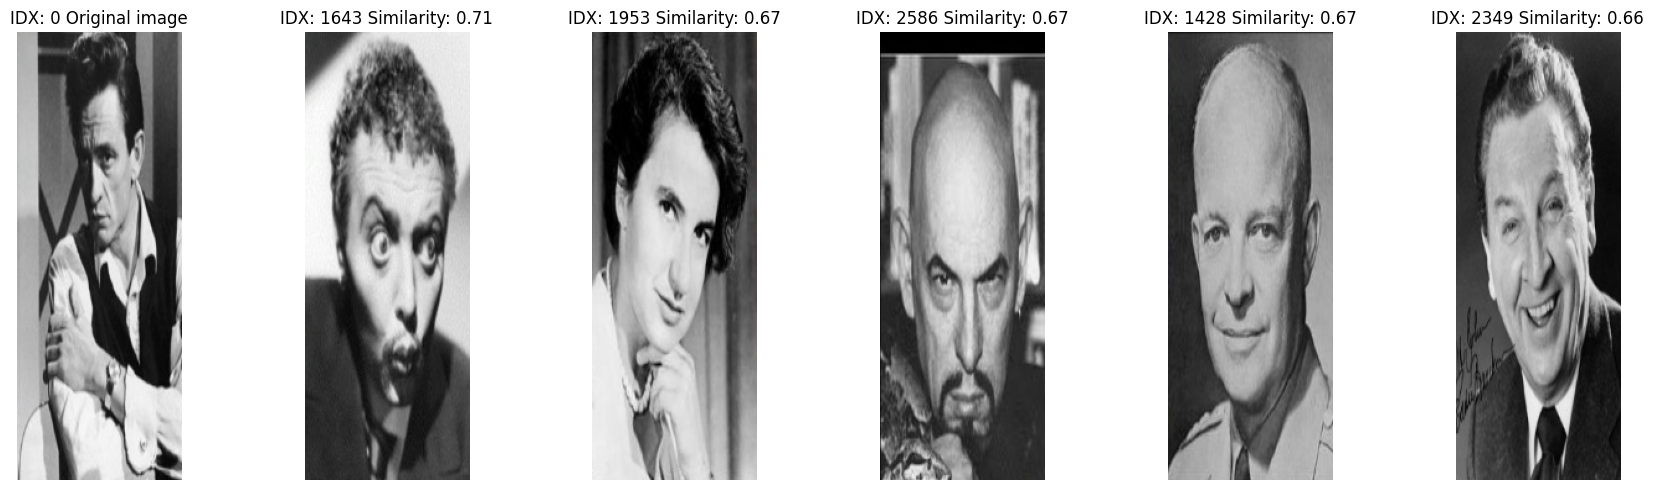

Finding similar images:  33%|███▎      | 1/3 [00:00<00:01,  1.91it/s]

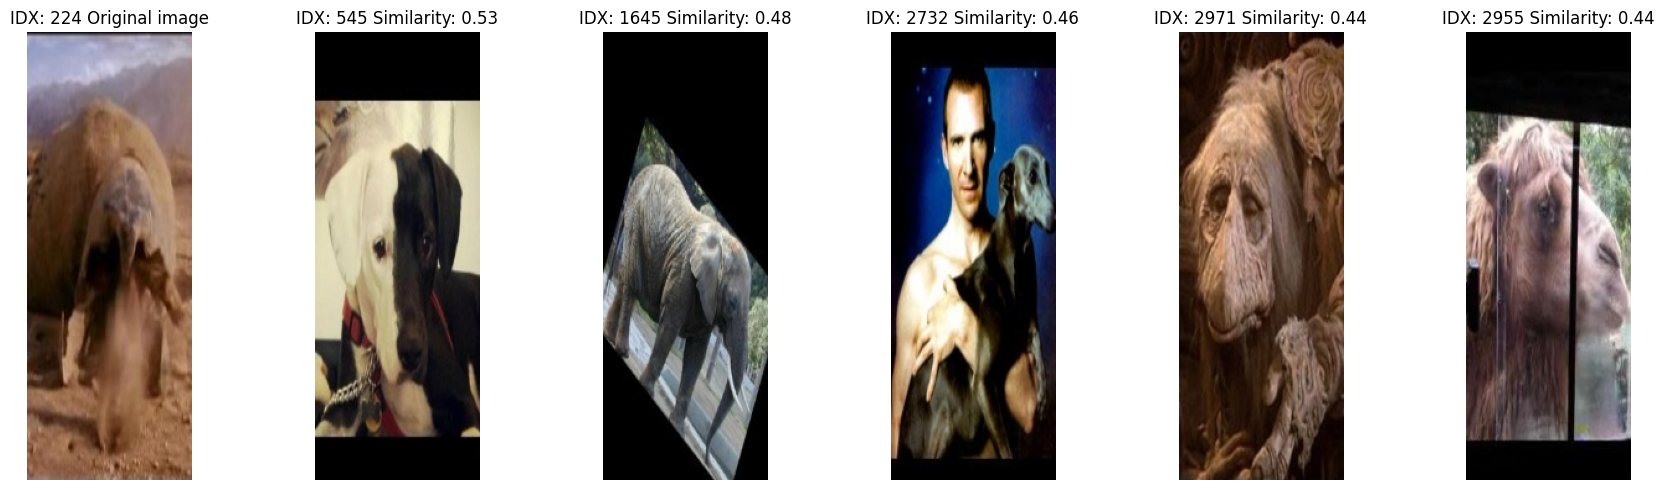

Finding similar images:  67%|██████▋   | 2/3 [00:01<00:00,  1.39it/s]

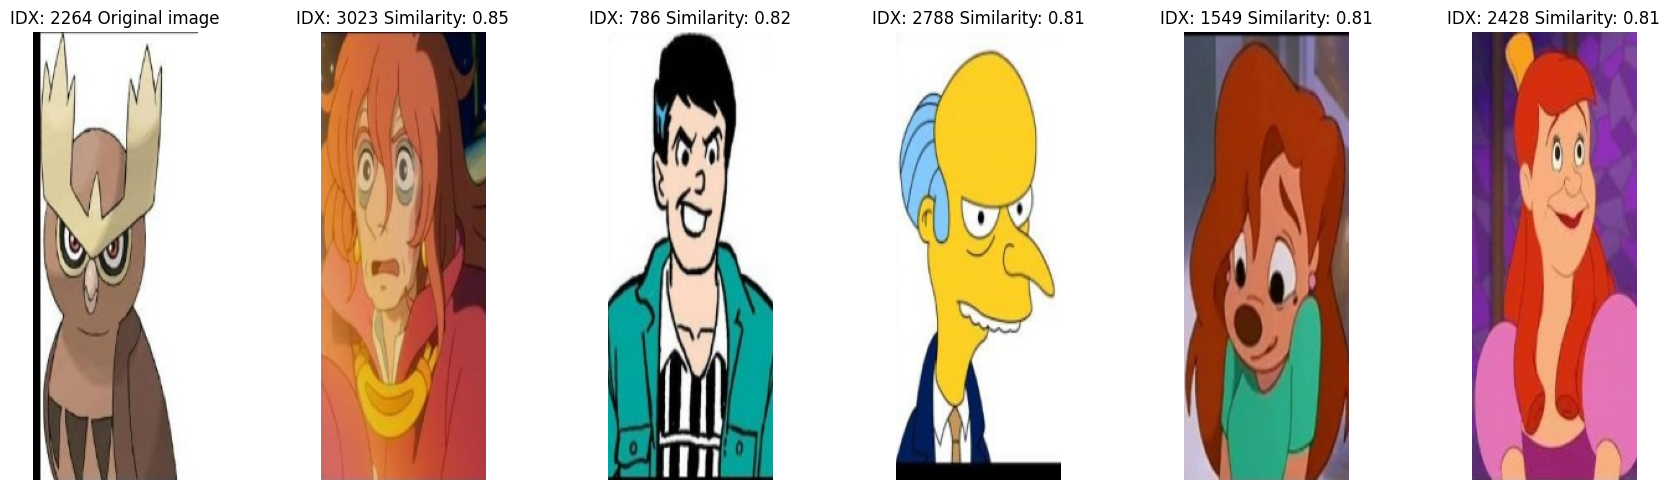

Finding similar images: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


In [ ]:
count = [0, 224, 2264] # Updated to include only valid indices
for original_index in tqdm(count, desc="Finding similar images"):
    similar_indices, similarity_scores = find_similar_images(vectors, original_index)
    display_results(images_paths, original_index, similar_indices, similarity_scores)